In [131]:
%reset -f
from CTR import *
import matplotlib.pyplot as plt

---

In [132]:

import json
import traceback
import pandas as pd
import numpy as np
import itertools

################################################################################################################

pi   = np.pi
inf  = np.inf
#
exp  = lambda x: np.exp(x)
#
def asin(x):
	x = np.round(x, 10)
	return np.arcsin(x)
#
vec  = lambda *args: np.array(args)
unit = lambda *args: vec(*args)/norm(vec(*args))
span = lambda eval, evec : np.tensordot(eval, evec, axes=0)
#
def norm(v):
	if len(v.shape)>1:
		return np.linalg.norm(v, axis=1)
	else: return np.linalg.norm(v)
def Crit(v):
	n = np.where(v==0, 1, v)
	v = np.where(v==0, 0, 1/n)
	v[(np.where(v==0)[0]+1)%3] *= -1
	return v
def Orthogonal(v):
	z = np.count_nonzero(v)
	if z==1:
		M = vec([0, 1, 0], [0, 0, 1], [1, 0, 0])
		return M@v, M@M@v
	if z==2: o = Crit(v)
	if z==3: o = Crit(vec(*v[0:2], 0))
	return (o, np.cross(v, o))

################################################################################################################



In [133]:
class Film():
	def __init__(self, molecule, N):
		# self.molecule, self.ref = molecule
		self.molecule = molecule
		self.N = vec(*N)
	def __call__(self, *args): return Sample(self, nref=args)
	def __truediv__(self, substrate):
		# Film/Sample
		if 'Sample' in str(substrate.__class__):
			return Sample(self, *substrate.FILMS, nref=substrate.nref)
		else:   # Film/Film
			return Sample(self, substrate, nref=None)
	def __or__(self, xray): 
		I = xray.I(self)
		return I/np.max(I)
	#
	def SN(self, Q): # X = Q @ molecule.abc
		# IX = 1j * Q * self.molecule.abc
		IX = 1j *  Q @ self.molecule.map
		Noinf = np.where(self.N == inf, 0, self.N)
		Noinf = np.where(Noinf == -inf, 0, Noinf)
		NUM = np.where(exp(IX)==1, Noinf, 1-exp(IX*Noinf))
		# bulk film
		NUM = np.where(self.N ==  inf,  1, NUM)
		# bulk substrate
		NUM = np.where(self.N == -inf, -1, NUM)
		DEN = np.where(exp(IX)==1, 1, 1-exp(IX))
		return np.prod(NUM/DEN, axis=1)
	#
	def F(self, Q, E=Xray().Energy): return self.molecule.SF(Q, E) * self.SN(Q)
	def I(self, Q, E=Xray().Energy): return np.abs(self.F(Q, E)) ** 2

---

In [134]:
from CTR.Atoms import Sr, Ti, O, Ir

In [135]:
XRD = Xray()
XRD.Q(0,0,1)

array([[0.        , 0.        , 0.0081568 ],
       [0.        , 0.        , 0.01631361],
       [0.        , 0.        , 0.02447041],
       ...,
       [0.        , 0.        , 8.14048934],
       [0.        , 0.        , 8.14864614],
       [0.        , 0.        , 8.15680294]])

In [136]:
sto = Perovskite(abc=(3.905, 3.905, 3.905), ABO=(Sr, Ti, O))
# sio = Perovskite(abc=Molecule.pseudocubic(5.64, 5.69, 7.94), ABO=(Sr, Ir, O))

test = Molecule(lattice=(3.905, 3.905, 3.905, 90, 120, 90), structure=sto.structure)
# test2 = Perovskite(abc=(3.905, 3.905, 3.905*np.sqrt(3)/2), ABO=(Sr, Ti, O))

#
STO = Film(sto, (10,10,10))
# SIO = Film(sio, (10,10,10))
TEST = Film(test, (10,10,10))
# TEST2 = Film(test2, (10,10,10))

In [137]:
# print(test.map)
# print(test2.map)

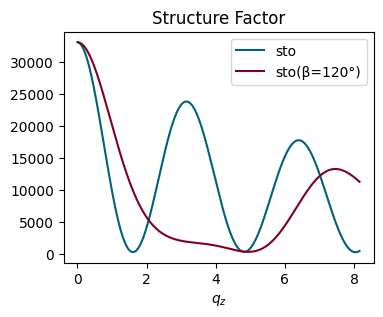

In [138]:
plt.close()
plt.figure(figsize=(4,3))
plt.title('Structure Factor')
plt.plot(XRD.qz, np.abs(XRD.SF(sto))**2, label='sto', color='#006080')
plt.plot(XRD.qz, np.abs(XRD.SF(test))**2, label='sto(β=120°)', color='#800020')
plt.xlabel('$q_z$')
plt.legend()

In [141]:
print(sto.map)
print(test.map)

[[3.905 0.    0.   ]
 [0.    3.905 0.   ]
 [0.    0.    3.905]]
[[ 3.905      0.        -1.9525   ]
 [ 0.         3.905      0.       ]
 [ 0.         0.         3.3818292]]


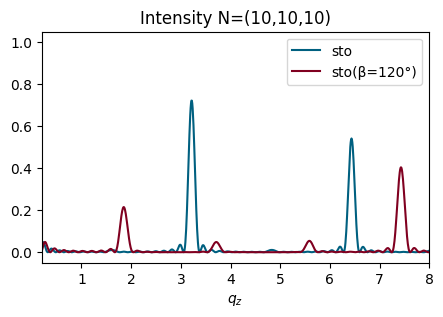

In [140]:
plt.close()
plt.figure(figsize=(5,3))
plt.title('Intensity N=(10,10,10)')
plt.plot(XRD.qz, STO|XRD, label='sto', color='#006080')
plt.plot(XRD.qz, TEST|XRD, label='sto(β=120°)', color='#800020')
plt.xlim([0.2, 8])
plt.xlabel('$q_z$')
plt.legend()